# Experiments for Inference and Analysis NCBI Yellow Fever

TBC

# 1. Imports and setup environment

In [2]:
# Install required custom packages if not installed yet.
import importlib.util
if not importlib.util.find_spec('ecutilities'):
    print('installing package: `ecutilities`')
    ! pip install -qqU ecutilities
else:
    print('`ecutilities` already installed')
if not importlib.util.find_spec('metagentools'):
    print('installing package: `metagentools')
    ! pip install -qqU metagentools
else:
    print('`metagentools` already installed')

`ecutilities` already installed
`metagentools` already installed


In [3]:
# Import all required packages
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import time

from datetime import datetime
from ecutilities.core import files_in_tree
from ecutilities.ipython import nb_setup
from functools import partial
from IPython.display import display, update_display, Markdown, HTML
from pandas import HDFStore
from pathlib import Path
from pprint import pprint
from tqdm.notebook import tqdm, trange

# Setup the notebook for development
nb_setup()

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.models import load_model
print(f"Tensorflow version: {tf.__version__}\n")

from metagentools.cnn_virus.data import _base_hot_encode, strings_to_tensors
from metagentools.cnn_virus.data import split_kmer_into_50mers, combine_predictions
from metagentools.cnn_virus.data import FastaFileReader, FastqFileReader, AlnFileReader
from metagentools.cnn_virus.data import OriginalLabels
from metagentools.cnn_virus.data import string_input_batch_to_tensors, split_kmer_batch_into_50mers
from metagentools.cnn_virus.architecture import create_model_original
from metagentools.core import ProjectFileSystem, TextFileBaseReader

Set autoreload mode
Tensorflow version: 2.8.2



List all computing devices available on the machine

In [4]:
devices = device_lib.list_local_devices()
print('\nDevices:')
for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':', 1) for item in name.split(', ')]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', ' ')
    print(f"  - {t}  {d.name} {dev:25s}")


Devices:
  - CPU  /device:CPU:0                          
  - GPU  /device:GPU:0  NVIDIA GeForce GTX 1050 


# 2. Setup paths to files

Key folders and system information

In [5]:
pfs = ProjectFileSystem()
pfs.info()

Running linux on local computer
Device's home directory: /home/vtec
Project file structure:
 - Root ........ /home/vtec/projects/bio/metagentools 
 - Data Dir .... /home/vtec/projects/bio/metagentools/data 
 - Notebooks ... /home/vtec/projects/bio/metagentools/nbs


- `p2model`: path to file with saved original pretrained model
- `p2virus_labels` path to file with virus names and labels mapping for original model

In [6]:
p2model = pfs.data / 'saved/cnn_virus_original/pretrained_model.h5'
assert p2model.is_file(), f"No file found at {p2model.absolute()}"

p2virus_labels = pfs.data / 'CNN_Virus_data/virus_name_mapping'
assert p2virus_labels.is_file(), f"No file found at {p2virus_labels.absolute()}"

# 3. Load simulated reads and review

Check which simread files are already created:

In [10]:
files_in_tree(pfs.data / 'ncbi/simreads/yf');

simreads
  |--yf
  |    |--readme.md (0)
  |    |--single_1seq_150bp
  |    |    |--single_1seq_150bp.fq (1)
  |    |    |--single_1seq_150bp.aln (2)
  |    |--single_69seq_150bp
  |    |    |--single_69seq_150bp.fq (3)
  |    |    |--single_69seq_150bp.aln (4)
  |    |--paired_1seq_150bp
  |    |    |--paired_1seq_150bp2.aln (5)
  |    |    |--paired_1seq_150bp2.fq (6)
  |    |    |--paired_1seq_150bp1.fq (7)
  |    |    |--paired_1seq_150bp1.aln (8)
  |    |--paired_69seq_150bp
  |    |    |--paired_69seq_150bp1.fq (9)
  |    |    |--paired_69seq_150bp2.fq (10)
  |    |    |--paired_69seq_150bp1.aln (11)
  |    |    |--paired_69seq_150bp2.aln (12)


In [7]:
p2fastq = pfs.data / 'ncbi/simreads/yf/single_1seq_150bp/single_1seq_150bp.fq'
assert p2fastq.exists()
p2aln = pfs.data / 'ncbi/simreads/yf/single_1seq_150bp/single_1seq_150bp.aln'
assert p2aln.exists()

In [44]:
fastq = FastqFileReader(p2fastq)
for i, fq_read in enumerate(fastq):
    pass
print(f"{i+1:,d} simulated reads in file {p2fastq.name}")

aln = AlnFileReader(p2aln)
for i, aln_read in enumerate(aln):
    pass
print(f"{i+1:,d} simulated reads in file {p2aln.name} from {len(aln.header['reference sequences'])} refseq.")

print(aln.header['command'])
print('\n'.join(aln.header['reference sequences']))

17,000 simulated reads in file single_1seq_150bp.fq
17,000 simulated reads in file single_1seq_150bp.aln from 1 refseq.
/usr/bin/art_illumina -i /home/vtec/projects/bio/metagentools/data/ncbi/refsequences/yf/yf_1971_angola.fa -ss HS25 -l 150 -f 250 -o /home/vtec/projects/bio/metagentools/data/ncbi/simreads/yf/single_1seq_150bp/single_1seq_150bp -rs 1724163574
@SQ	11089:ncbi:1	1	AY968064	11089	ncbi	Angola_1971	10237


# Prediction Loop

Label for Yellow Fever in `118`

In [45]:
[(k,v) for k, v in OriginalLabels()._species2label.items() if 'yellow' in k.lower()]

[('Yellow_fever_virus', 118)]

Let's test:
- the generator (`aln.cnn_virus_input_generator`)
- the string to tensor transform function (`string_input_batch_to_tensors`)

In [46]:
aln.reset_iterator()
for batch in aln.cnn_virus_input_generator(bs=8, label=118):
    read_kmer_tensor, (label_tensor, position_tensor) = string_input_batch_to_tensors(batch, k=150)
    break

read_kmer_tensor.shape, label_tensor.shape, position_tensor.shape

(TensorShape([8, 150, 5]), TensorShape([8, 187]), TensorShape([8, 10]))

Then we apply `split_kmer_batch_into_50mers` to split the kmers into a series of 50-mer reads.

In [47]:
read_50mer_tensor = split_kmer_batch_into_50mers(read_kmer_tensor)

print('Nb 50-mer reads in a batch: ',(read_kmer_tensor.shape[1]-49) * read_kmer_tensor.shape[0])
assert read_50mer_tensor.shape == ((kmer_tensor.shape[1]-49) * kmer_tensor.shape[0], 50,5)

read_50mer_tensor.shape, 

Nb 50-mer reads in a batch:  808


(TensorShape([808, 50, 5]),)

In [48]:
def combine_label_predictions(probs_elements, prob_threshold=0.9):
    """???"""

    label_probs = probs_elements[0]
    position_probs = probs_elements[1]

    labels_preds = tf.argmax(label_probs, axis=1)
    positions_preds = tf.argmax(position_probs, axis=1)

    valid_labels_filter = tf.reduce_max(label_probs, axis=1) > prob_threshold
    valid_labels_preds = labels_preds[valid_labels_filter]
    
    valid_positions_preds = positions_preds[valid_labels_filter]


    if valid_labels_preds.shape[0] == 0:
        combined_label = tf.constant(187, shape=(1,), dtype=tf.int64)
        combined_position = tf.constant(10, shape=(1,), dtype=tf.int64)

    else:
        uniques, _, counts = tf.unique_with_counts(valid_labels_preds)
        combined_label = uniques[tf.argmax(counts)]

        # filter which reads give the majority label prediction
        combined_label_filter = valid_labels_preds == combined_label

        # pick the corresponding position predictions
        filtered_positions = valid_positions_preds[combined_label_filter]
        unique_positions, _, counts = tf.unique_with_counts(filtered_positions)
        combined_position = unique_positions[tf.argmax(counts)]

        combined_pred = tf.concat([combined_label, combined_position], axis=0)

    return combined_pred

In [49]:
def top_predictions(probs, n=3):

    def top_n_most_frequent(preds, n=3):
        """Returns the top n most frequent predictions for each read"""
        # print(preds.shape)
        uniques, counts = np.unique(preds, return_counts=True)
        top_idx = np.argsort(counts)[-n:]
        return uniques.take(top_idx)

    top_preds_in_50mers = np.argsort(probs, axis=-1)[:, :, -n:]
    nb_seq, nb_50mer, nb_lbls = top_preds_in_50mers.shape
    # print(top_preds_in_50mers.shape)
    top_preds_in_kmer = top_preds_in_50mers.reshape(nb_seq,nb_50mer * nb_lbls)
    # print(top_preds_in_kmer.shape)

    return np.apply_along_axis(top_n_most_frequent, axis=1, arr=top_preds_in_kmer, n=n)

# top_predictions(label_probs_per_kmer, n=3)

In [102]:
def count_successive_label_preds(label_probs_per_kmer):
    series = []
    label_preds_per_kmer = tf.argmax(label_probs_per_kmer, axis=2)
    same_as_next = tf.roll(label_preds_per_kmer, shift=-1, axis=1) == label_preds_per_kmer
    same_as_previous = tf.roll(label_preds_per_kmer, shift=+1, axis=1) == label_preds_per_kmer
    xor = tf.bitwise.bitwise_xor(tf.cast(same_as_next, dtype=tf.int16), tf.cast(same_as_previous, dtype=tf.int16))
    for i in range(b):
        kmer_series_idxs = tf.range(k-49)[tf.cast(xor[i], dtype=tf.bool)]
        start_idxs = kmer_series_idxs[0::2]
        end_idxs = kmer_series_idxs[1::2]
        kmer_series = {key: [] for key in range(187)}
        for s,e in zip(start_idxs, end_idxs):
            kmer_series[label_preds_per_kmer[i,s].numpy().item()].append((e-s+1).numpy().item())
        series.append(kmer_series)
    return series

In [197]:
from tqdm.notebook import tqdm, trange

In [ ]:
series = []
label_preds_per_kmer = tf.argmax(label_probs_kmer, axis=2)
same_as_next = tf.roll(label_preds_per_kmer, shift=-1, axis=1) == label_preds_per_kmer
same_as_previous = tf.roll(label_preds_per_kmer, shift=+1, axis=1) == label_preds_per_kmer
xor = tf.bitwise.bitwise_xor(tf.cast(same_as_next, dtype=tf.int16), tf.cast(same_as_previous, dtype=tf.int16))
or_ = tf.bitwise.bitwise_or(tf.cast(same_as_next, dtype=tf.int16), tf.cast(same_as_previous, dtype=tf.int16))
for i in trange(b):
    kmer_series_idxs = tf.range(k-49)[tf.cast(xor[i], dtype=tf.bool)]
    start_idxs = kmer_series_idxs[0::2]
    end_idxs = kmer_series_idxs[1::2]
    kmer_series = {key: [] for key in range(187)}
    for s,e in zip(start_idxs, end_idxs):
        kmer_series[label_preds_per_kmer[i,s].numpy().item()].append((e-s+1).numpy().item())
    series.append(kmer_series)
series

In [256]:
def count_(label_preds_per_kmer):
    n = min(25, label_preds_per_kmer.shape[1])
    slice_o = slice(0,n)
    lbl = label_preds_per_kmer[0:1]
    same_as_next = tf.roll(lbl, shift=-1, axis=1) == lbl
    same_as_previous = tf.roll(lbl, shift=+1, axis=1) == lbl
    xor = tf.bitwise.bitwise_xor(tf.cast(same_as_next, dtype=tf.int16), tf.cast(same_as_previous, dtype=tf.int16))
    or_ = tf.bitwise.bitwise_or(tf.cast(same_as_next, dtype=tf.int16), tf.cast(same_as_previous, dtype=tf.int16))

    for r,p,n in zip(lbl, tf.roll(lbl, shift=-1, axis=1), tf.roll(lbl, shift=+1, axis=1)):
        t = pd.DataFrame(
            {
                '-1': same_as_next.numpy().astype(int)[0,slice_o],
                'r': r.numpy()[slice_o], 
                'p': p.numpy()[slice_o], 
                'n': n.numpy()[slice_o],
                '+1': same_as_previous.numpy().astype(int)[0,slice_o],
                'or': or_.numpy().astype(int)[0,slice_o],
                'xor': xor.numpy().astype(int)[0,slice_o],
                }
            )
        display(t.T)

    return lbl, xor, or_
        

lbl, xor, or_ = count_(label_preds_per_kmer)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
-1,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
r,62,88,2,62,62,62,2,71,5,18,...,118,2,118,118,71,151,62,4,151,151
p,88,2,62,62,62,2,71,5,18,22,...,2,118,118,71,151,62,4,151,151,12
n,20,62,88,2,62,62,62,2,71,5,...,71,118,2,118,118,71,151,62,4,151
+1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
or,0,0,0,1,1,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,1
xor,0,0,0,1,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,1


In [291]:
l1 = [[ 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20]]
l2 = [[ 1, 2, 3, 4, 5, 5, 5, 5, 5,10,11,12,13,14,15,16,17,18,19,20]]
l3 = [[ 1, 2, 3, 4, 5, 5, 5, 6, 6, 6, 6, 6,13,14,15,16,17,18,19,20]]
l4 = [[ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,11,12,13,14,15,16,17,18,19,20]]
l5 = [[ 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 8, 8, 8, 9,10,11]]
l6 = [[ 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9,10,10]]

for l in [l1, l2, l3]:#, l4]: #, l5, l6]:
    ts = tf.convert_to_tensor(l)
    lbl, xor, or_ = count_(ts)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
r,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
p,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,1
n,20,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
+1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
or,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
xor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
r,1,2,3,4,5,5,5,5,5,10,11,12,13,14,15,16,17,18,19,20
p,2,3,4,5,5,5,5,5,10,11,12,13,14,15,16,17,18,19,20,1
n,20,1,2,3,4,5,5,5,5,5,10,11,12,13,14,15,16,17,18,19
+1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
or,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
xor,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,0,0,0,0,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0
r,1,2,3,4,5,5,5,6,6,6,6,6,13,14,15,16,17,18,19,20
p,2,3,4,5,5,5,6,6,6,6,6,13,14,15,16,17,18,19,20,1
n,20,1,2,3,4,5,5,5,6,6,6,6,6,13,14,15,16,17,18,19
+1,0,0,0,0,0,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0
or,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0
xor,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0


In [391]:
l = [[ 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19,20],
     [ 1, 2, 3, 4, 5, 5, 5, 5, 5,10,11,12,13,14,15,16,17,18,19,20],
     [ 1, 2, 3, 4, 5, 5, 5, 6, 6, 6, 6, 6,13,14,15,16,17,18,19,20],
     [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,11,12,13,14,15,16,17,18,19,20],
     [ 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 8, 8, 8, 9,10,11],
     [ 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9,10,10]]

ts = tf.convert_to_tensor(l)

print(ts.shape)
display(pd.DataFrame(data=ts.numpy()))

n = min(25, ts.shape[1])
slice_o = slice(0,n)

same_as_next = tf.roll(ts, shift=-1, axis=1) == ts
same_as_previous = tf.roll(ts, shift=+1, axis=1) == ts
xor = tf.bitwise.bitwise_xor(tf.cast(same_as_next, dtype=tf.int16), tf.cast(same_as_previous, dtype=tf.int16))
or_ = tf.bitwise.bitwise_or(tf.cast(same_as_next, dtype=tf.int16), tf.cast(same_as_previous, dtype=tf.int16))

row = tf.expand_dims(tf.range(0,20), axis=0)
idxs = tf.repeat(row, repeats=6, axis=0)

row_cols_or = tf.where(tf.cast(or_,dtype=tf.bool))
row_cols_xor = tf.where(tf.cast(xor,dtype=tf.bool))

row_col_idx = np.append(row_cols_or.numpy(), np.expand_dims(idxs_or.numpy(),axis=1), axis=1)
row_col_idx.shape

sequences = {}
for i in range(ts.shape[0]):
    d = {'or':row_cols_or[row_cols_or[:,0] == i][:, 1],
         'xor':row_cols_xor[row_cols_xor[:,0] == i][:, 1]}
    sequences[i] = d
    print(f"{i:2d}  {sequences[i]['or'].numpy().tolist()}")
    print(f"    {sequences[i]['xor'].numpy().tolist()}")


(6, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,1,2,3,4,5,5,5,5,5,10,11,12,13,14,15,16,17,18,19,20
2,1,2,3,4,5,5,5,6,6,6,6,6,13,14,15,16,17,18,19,20
3,1,1,1,1,1,1,1,1,1,1,11,12,13,14,15,16,17,18,19,20
4,1,1,1,2,2,2,3,3,3,3,4,4,4,4,8,8,8,9,10,11
5,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10


 0  []
    []
 1  [4, 5, 6, 7, 8]
    [4, 8]
 2  [4, 5, 6, 7, 8, 9, 10, 11]
    [4, 6, 7, 11]
 3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    [0, 9]
 4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
    [0, 2, 3, 5, 6, 9, 10, 13, 14, 16]
 5  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [399]:
nb = 4
display(l[nb])
# display(sequences[nb]['or'].numpy().tolist(),sequences[nb]['or'][0::2].numpy().tolist(),sequences[nb]['or'][1::2].numpy().tolist())
display(sequences[nb]['xor'].numpy().tolist(),sequences[nb]['xor'][0::2].numpy().tolist(),sequences[nb]['xor'][1::2].numpy().tolist())

[1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 8, 8, 8, 9, 10, 11]

[0, 2, 3, 5, 6, 9, 10, 13, 14, 16]

[0, 3, 6, 10, 14]

[2, 5, 9, 13, 16]

# Run the Loop

Before running the next cell, define:
- size of the batch `b`
- the number of bp in a k-mer
- the number n for top-n predictions to save
- whether to run the full loop or only a few batches

In [103]:
fastq = FastqFileReader(p2fastq);
aln = AlnFileReader(p2aln)
p2fastq.stem

'single_1seq_150bp'

In [104]:
print(b, label_probs.shape, nb_50mer, label_probs.shape[0]/nb_50mer)

tf.reshape(label_probs, shape=(b,nb_50mer,-1)).shape

4 (404, 187) 101 4.0


TensorShape([4, 101, 187])

In [151]:
b = 512    # number of k-mer in a batch
k = 150
top_n = 5   # n for top-n prediction to keep
run_all_batches = False
nb_batches_to_run = 2

uid = datetime.today().strftime('%Y-%m-%d_%H_%M_%S')

p2result_folder = pfs.data /'ncbi/infer_results/yf-ncbi'
p2results = p2result_folder / f"{p2fastq.stem}-{uid}-results.csv"
p2probs = p2result_folder / f"{p2fastq.stem}-{uid}-probs.csv"
p2probs_h5 = p2result_folder / f"{p2fastq.stem}-{uid}-probs.h5"

nb_50mer = k - 49
print(f"Run prediction loop with the following parameters:")
print(f"   {b} k-mer per batch; {k} bp per sequence; keep top-{top_n} predictions")

aln.reset_iterator()
model = create_model_original(path2parameters=p2model)
print(f"Model loaded and ready to run ...")

# create a dataframe to store results
pred_cols = ['lbl_pred','pos_pred']
top_pred_cols = [f"top_{top_n}_lbl_pred_{i}" for i in range(top_n)]
prob_cols = [f"Read{i}ProbLbl{j}" for i in range(k-49) for j in range(187)]
df = pd.DataFrame(
    columns=pred_cols + top_pred_cols + ['series']
)

df_probs = pd.DataFrame(
    columns= prob_cols,
    dtype=float
)

df.to_csv(p2results)
df_probs.to_csv(p2probs)
# df_probs.to_hdf(p2probs_h5, key='df', mode='w', format='table', append=True)
print(f"results will be saved to {p2results.absolute()} and \nprobs will be saved to {p2probs.absolute()}")

def tprint(string):
    print(f"{datetime.now().strftime('%H:%M:%S')}    {string}")

print(f"Starting prediction loop ...")
for i,(ids_batch, reads_batch) in enumerate(aln.cnn_virus_input_generator(bs=b, label=118)):
    loop_start = datetime.now()
    tprint(f"Batch {i+1:3d} ...")

    read_kmers, (true_labels, true_positions) = string_input_batch_to_tensors(reads_batch, k=k)
    read_50mers = split_kmer_batch_into_50mers(read_kmers)
    assert read_50mers.shape == ((read_kmers.shape[1]-49) * b, 50, 5), f"Problem with shape in batch {i+1}"

    tprint('  Starting prediction ...')
    label_probs, position_probs = model.predict(read_50mers)
    label_probs_kmer = tf.reshape(label_probs, shape=(b,nb_50mer,-1))
    position_probs_kmer = tf.reshape(position_probs, shape=(b,nb_50mer,-1))
    successive_preds = count_successive_label_preds(label_probs_kmer)

    tprint('  Combine predictions ...')
    combined_predictions = tf.map_fn(
        fn=combine_label_predictions,
        elems=[label_probs_kmer, position_probs_kmer], 
        fn_output_signature=tf.int64
        )
    
    label_predictions = combined_predictions[:,0]
    position_predictions = combined_predictions[:,1]
    top_preds = top_predictions(label_probs_kmer, n=top_n)

    # Add results for batch
    tprint('  Prepare batch result reports and save them ...')
    results = np.concatenate(
        [
            np.expand_dims(label_predictions.numpy(), axis=1),
            np.expand_dims(position_predictions.numpy(), axis=1),
            top_preds[:, ::-1],
            np.expand_dims(np.array(successive_preds), axis=1)
        ],
        axis=1
    )
    df = pd.DataFrame(
        data=results, 
        index=ids_batch, 
        columns=df.columns
        )
    df.to_csv(p2results, mode='a', header=False)
    
    df_probs = pd.DataFrame(
        data=label_probs_kmer.numpy().reshape(b, -1), 
        index=ids_batch, 
        columns=df_probs.columns
        )
    df_probs.to_csv(p2probs, mode='a', header=False)
    # df_probs.to_hdf(p2probs_h5, key='df', mode='a', format='table', complevel=0)
    # df_probs.to_hdf(p2probs_h5, key='df', mode='a', format='table', append=True)

    tprint(f"  Batch processing time: {(datetime.now() - loop_start).total_seconds():.2f} sec")
    if i+1 >= nb_batches_to_run: 
        print('Stopping')
        break

Run prediction loop with the following parameters:
   512 k-mer per batch; 150 bp per sequence; keep top-5 predictions
Creating CNN Model (Original)
Loading parameters from pretrained_model.h5
Created pretrained model
Model loaded and ready to run ...
results will be saved to /home/vtec/projects/bio/metagentools/data/ncbi/infer_results/yf-ncbi/single_1seq_150bp-2024-08-21_16_22_45-results.csv and 
probs will be saved to /home/vtec/projects/bio/metagentools/data/ncbi/infer_results/yf-ncbi/single_1seq_150bp-2024-08-21_16_22_45-probs.csv
Starting prediction loop ...
16:22:46    Batch   1 ...
16:22:47      Starting prediction ...
16:23:30      Combine predictions ...
16:23:39      Prepare batch result reports and save them ...
16:23:51      Batch processing time: 64.40 sec
16:23:51    Batch   2 ...
16:23:51      Starting prediction ...
16:24:35      Combine predictions ...
16:24:46      Prepare batch result reports and save them ...
16:24:58      Batch processing time: 67.48 sec
Stopping


# Analysis Ideas

Other Ideas:
- Analysing the False Negatives (top-k)
- Can we identify a False negative vs a True Positive from the probabilities of all 101 50-mers?

Generate features from extracted series lengths, for each label or the top k labels evalaute for each k-mer
- number of series
- average length
- maximum length
- cummulative lengths of series ($\sum_{series}{}$ lengths of serie)
- standard deviation of length

Generate statistics feature over all 50-mer for each k-mer (for all labels or the top k):
- min probability across 101 50-mer
- max probability
- mean probability
- standard deviation probability
- count 50-mer probability in given quantile [(pd doc)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html)


Generate bio features:
- position of read for TP and FN
- mapping with the probabilities

## Analyse accuracy per accession

In [ ]:
p2result_folder = pfs.data /'ncbi/infer_results/yf'
files_in_tree(path=p2result_folder);

In [ ]:
# p2resfile = pfs.project_root /'data/ncov_data/reads/yf/yf-mapped-results-2024-04-29_17_31_10.csv'
p2resfile = p2result_folder /'yf_2023-single-69seq-150bp-2024-05-02_16_29_18-results.csv'
assert p2resfile.is_file()

df = pd.read_csv(p2resfile, index_col=0)
print(df.shape)
df.head()

In [ ]:
lbls = OriginalLabels(p2mapping=p2virus_labels)
lbls.label2species(118)

In [ ]:
df.loc[df.lbl_pred == 118, :].shape

In [ ]:
29367 / df.shape[0]

In [ ]:
df['accession'] = df.index
pattern = r'^@(?P<refseqid>(?P<refseq_accession>[a-zA-Z0-9]+).*)-(?P<readnb>\d+)$'
df['accession'] = df.loc[:, 'accession'].str.replace(pattern, r'\g<refseq_accession>', regex=True)
df.head(3)

In [ ]:
by_accession = df.groupby('accession', sort=True)

In [ ]:
count_by_accession = by_accession['lbl_pred'].count()
count_by_accession

In [ ]:
correct_by_accession = (df.loc[df.lbl_pred == 118, :]).groupby('accession')
count_correct_by_accession = correct_by_accession['lbl_pred'].count()
count_correct_by_accession

In [ ]:
accuracy_by_accession = count_correct_by_accession / count_by_accession
accuracy_by_accession

In [ ]:
display(accuracy_by_accession.sort_values(ascending=True)[:20])
display(accuracy_by_accession.sort_values(ascending=False)[:20])

In [ ]:
read_ids = list(df.index)
pattern = r'^@(?P<refseqid>(?P<refseq_accession>[a-zA-Z0-9]+).*)-(?P<readnb>\d+)$'

ids_set = set([re.sub(pattern, r'\g<refseqid>', s) for s in read_ids])
accessions_set = set([re.sub(pattern, r'\g<refseq_accession>', s) for s in read_ids])

In [ ]:
len(ids_set), len(accessions_set)

In [ ]:
mapping_accession_refseq_id = {}
for accession in accessions_set:
    temp_accession = None
    for read_id in ids_set:
        if accession in read_id:
            if temp_accession is None:
                temp_accession = accession
                mapping_accession_refseq_id[accession] = read_id
                continue
            else:
                print(f"{accession} in two read ids: {temp_accession} and {read_id}")
                continue
mapping_accession_refseq_id

In [ ]:
accuracy_by_accession.index = [mapping_accession_refseq_id[idx] for idx in accuracy_by_accession.index]

In [ ]:
accuracy_by_accession.sort_values(ascending=False)[:33]

In [ ]:
accuracy_by_accession.sort_values(ascending=True)[:20]

## Analyse same prediction series

Define the top k predicted label

In [ ]:
cols = 'top_5_lbl_pred_0 top_5_lbl_pred_1 top_5_lbl_pred_2 top_5_lbl_pred_3 top_5_lbl_pred_4'.split(' ')
uniques, counts = np.unique(df.loc[:, cols].values.reshape(5 * df.shape[0], -1), return_counts=True)
uniques, counts

In [ ]:
sorted_idxs = np.flip(np.argsort(counts))

In [ ]:
k = 15
top_k_lbl = uniques[sorted_idxs[:k]].tolist()
coverage = (counts[sorted_idxs[:k]]/counts.sum()).sum()
print(f"The following {k} labels represents {coverage*100:2.0f}% of all predicted labels")
print(top_k_lbl)

In [ ]:
json

In [ ]:
def extract_top_k_lengths(d, top_k):
    top_k_dict = {}
    for lbl in top_k:
        top_k_dict[lbl] = d.get(lbl, [])
    return top_k_dict

extract_top_k_lengths(df.series.to_list()[0], top_k_lbl)

## Analyse prediction probabilities

### Define functions

In [152]:
def plot_label_probs(probs, top_preds, targets):
    nb_seq, _ , nb_lbls = probs.shape
    assert nb_lbls == 187
    fig = plt.figure(figsize=(16, 2 * nb_seq - 1));
    # fig.suptitle('Suptitle')
    axs = []
    for i in range(nb_seq):
        if top_preds[i, 0] in targets: cmap = 'YlGn_r'
        else: cmap = 'YlOrRd_r'
        axs.append(plt.subplot2grid((nb_seq,1), (i,0), rowspan=1, colspan=1))
        # axs[i].axis('off')
        axs[i].imshow(probs[i,:,:], cmap=cmap, aspect='auto')
        axs[i].set_title(f"Seq {i+1} - Pred: {top_preds[i,0]} - Top Predictions; {top_preds[i]}")

    fig.subplots_adjust(top=1.5, bottom=0.2, hspace=0.5)
    plt.show()

## Handle entire result file

Next cell load the entire result file. It takes a while to load.

If the file is too big, it may fail. In that case, load the file in chunks and handle each chunck separately (see lower cells).

In [153]:
paths = files_in_tree(path=pfs.data / 'ncbi/infer_results/yf-ncbi')

infer_results
  |--yf-ncbi
  |    |--single_1seq_150bp-2024-08-21_16_22_45-probs.csv (0)
  |    |--readme.md (1)
  |    |--single_1seq_150bp-2024-08-21_16_22_45-results.csv (2)


In [154]:
fnbr = 2
assert paths[fnbr].is_file()
p2resfile = paths[fnbr]

df = pd.read_csv(p2resfile, index_col=0)
print(df.shape)
df.head()

(1024, 8)


,lbl_pred,pos_pred,top_5_lbl_pred_0,top_5_lbl_pred_1,top_5_lbl_pred_2,top_5_lbl_pred_3,top_5_lbl_pred_4,series
11089:ncbi:1-17000,32,7,18,0,32,117,118,"{0: [5, 2, 9], 1: [], 2: [], 3: [], 4: [], 5: ..."
11089:ncbi:1-16999,118,7,118,137,103,130,144,"{0: [2], 1: [], 2: [], 3: [], 4: [], 5: [], 6:..."
11089:ncbi:1-16998,4,6,4,12,160,59,32,"{0: [], 1: [], 2: [], 3: [], 4: [7, 3, 2, 2], ..."
11089:ncbi:1-16997,20,7,62,20,6,67,73,"{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: ..."
11089:ncbi:1-16996,62,2,62,67,151,18,0,"{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: ..."


In [155]:
fnbr = 0
assert paths[fnbr].is_file()

print(f"Reading file {paths[fnbr]}")
# df_probs = pd.read_hdf(paths[fnbr], key='df')
df_probs = pd.read_csv(paths[fnbr])
print(df_probs.shape)
df_probs.head()

Reading file /home/vtec/projects/bio/metagentools/data/ncbi/infer_results/yf-ncbi/single_1seq_150bp-2024-08-21_16_22_45-probs.csv
(1024, 18888)


,Unnamed: 0,Read0ProbLbl0,Read0ProbLbl1,Read0ProbLbl2,Read0ProbLbl3,Read0ProbLbl4,Read0ProbLbl5,Read0ProbLbl6,Read0ProbLbl7,Read0ProbLbl8,...,Read100ProbLbl177,Read100ProbLbl178,Read100ProbLbl179,Read100ProbLbl180,Read100ProbLbl181,Read100ProbLbl182,Read100ProbLbl183,Read100ProbLbl184,Read100ProbLbl185,Read100ProbLbl186
0,11089:ncbi:1-17000,3.077912e-09,4.655054e-16,4.005901e-09,5.709354e-14,3.985621e-13,1.478135e-07,3.636883e-13,7.638156e-13,2.044867e-17,...,2.981896e-11,1.488554e-12,6.011380e-01,5.832164e-17,3.137942e-08,1.386401e-11,7.054615e-14,4.146255e-09,5.936590e-15,3.292315e-18
1,11089:ncbi:1-16999,1.112671e-20,1.447223e-18,1.164046e-14,1.550676e-14,4.486694e-18,3.165934e-20,2.112465e-16,5.348861e-15,9.968459e-17,...,4.290858e-05,7.721715e-19,7.660002e-08,1.958195e-19,6.709278e-12,4.541483e-16,1.055118e-10,9.869940e-18,1.314571e-17,4.655303e-16
2,11089:ncbi:1-16998,2.262924e-07,7.513288e-14,1.033728e-06,2.323154e-13,1.778804e-12,1.023959e-12,1.822989e-01,1.191096e-12,1.946499e-07,...,8.152968e-19,1.684802e-21,4.228031e-17,4.717138e-18,5.818298e-16,7.844328e-15,3.435846e-12,1.400712e-17,4.134293e-19,1.694941e-23
3,11089:ncbi:1-16997,5.314042e-16,1.520063e-21,9.554766e-12,4.102489e-17,5.334006e-16,1.636212e-07,3.032553e-17,2.532097e-06,2.377029e-14,...,3.459278e-16,1.624415e-15,6.461179e-16,2.305965e-10,1.332486e-15,1.961612e-12,3.712050e-19,1.963319e-12,9.124885e-13,3.314686e-14
4,11089:ncbi:1-16996,7.672027e-15,5.821550e-19,2.513323e-09,7.068174e-13,5.544588e-19,2.790667e-10,2.509262e-16,1.444534e-12,1.900581e-14,...,5.030486e-11,1.291500e-10,1.442012e-11,1.130410e-20,1.574532e-08,1.079894e-17,2.106572e-14,1.665335e-16,1.261701e-17,3.627423e-15


In [156]:
df_probs.index

RangeIndex(start=0, stop=1024, step=1)

In [ ]:
# p2hdf5 = paths[fnbr].parent / f"{paths[fnbr].stem}.h5"
# assert p2hdf5.suffix == '.h5'
# df_probs.to_hdf(p2hdf5, key='df', mode='w', format='table', complevel=0)

In [157]:
187 * 101

df_probs.dtypes

Unnamed: 0            object
Read0ProbLbl0        float64
Read0ProbLbl1        float64
Read0ProbLbl2        float64
Read0ProbLbl3        float64
                      ...   
Read100ProbLbl182    float64
Read100ProbLbl183    float64
Read100ProbLbl184    float64
Read100ProbLbl185    float64
Read100ProbLbl186    float64
Length: 18888, dtype: object

In [158]:
probs_per_kmer = df_probs[prob_cols].to_numpy().reshape(df_probs.shape[0], -1, 187)
top_preds = df[top_pred_cols].to_numpy()
preds = top_preds[:, 0]

In [159]:
correct_pred_idxs = preds == 118
incorrect_pred_idxs = preds != 118
true_positives = correct_pred_idxs.sum()
false_negatives = incorrect_pred_idxs.sum()
accuracy = true_positives/(true_positives + false_negatives)
print(f"True positives:  {true_positives}")
print(f"False negatives: {false_negatives}")
print(f"Accuracy:        {accuracy:.2%}")

True positives:  174
False negatives: 850
Accuracy:        16.99%


### Plot prediction probabilities

#### Mixed predictions

Show profile of 101 label probabilities of each 50-mer corresponding to a k-mer read

There are about 17k reads, do not use this function for more than 50 reads at the time

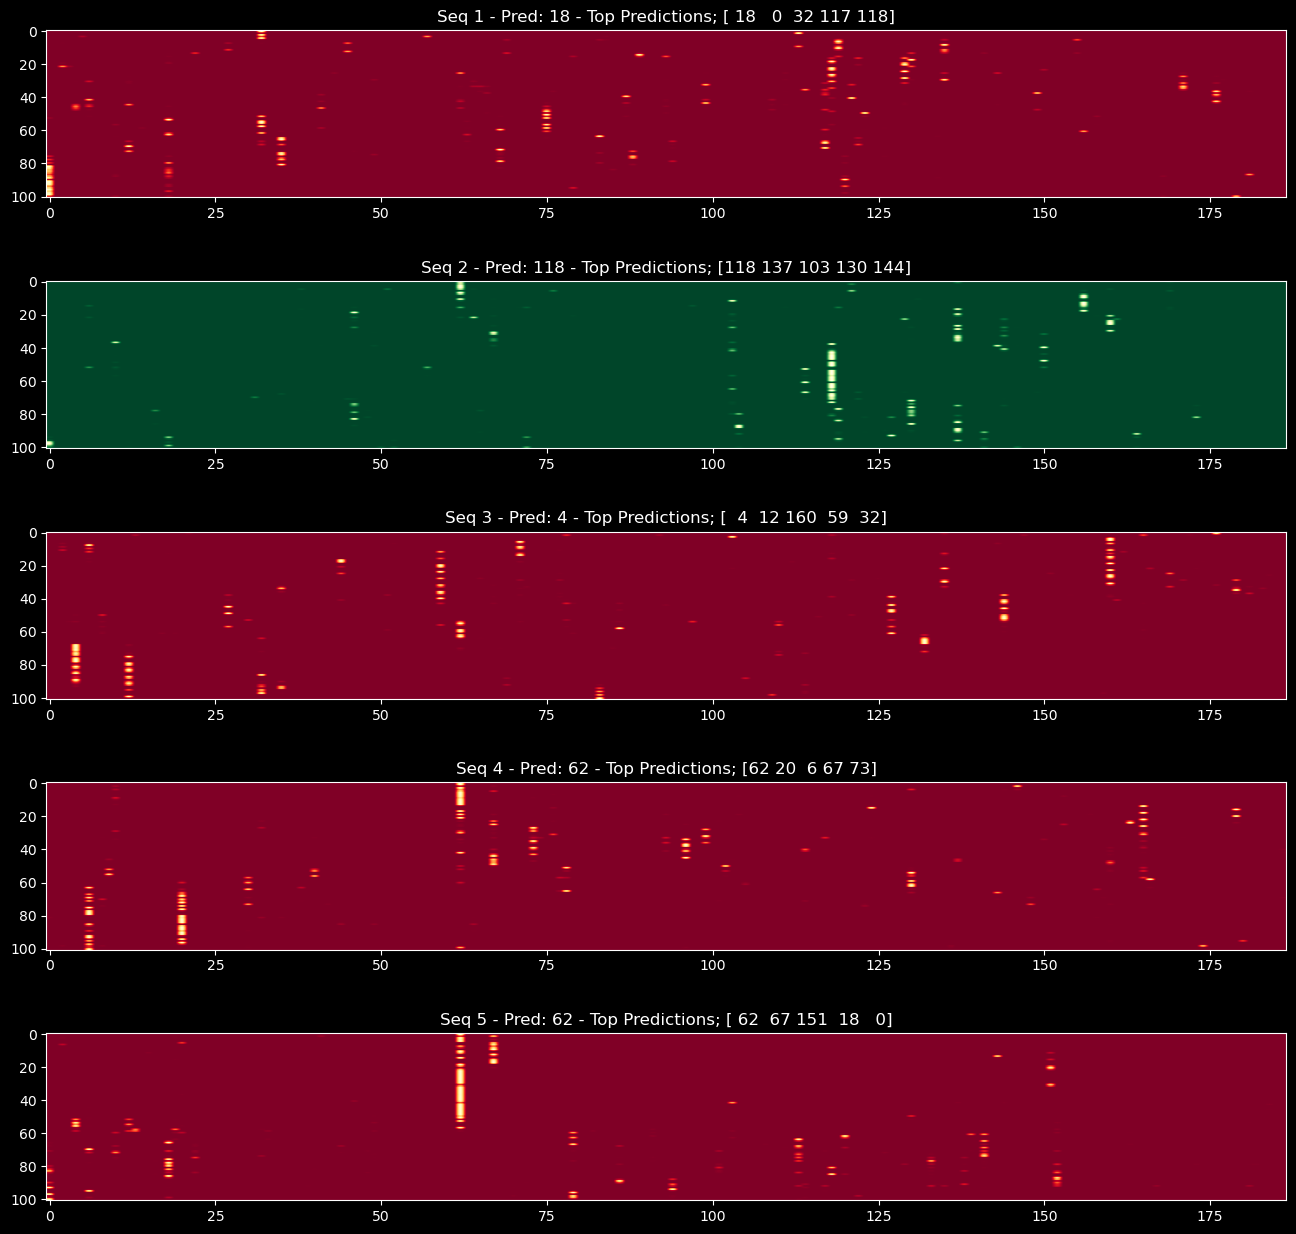

In [164]:
first_seq = 0
nb_seq = 5
s = slice(first_seq, first_seq+nb_seq)

plot_label_probs(probs_per_kmer[s,:,:], top_preds[s], [118])

#### True Positive Only

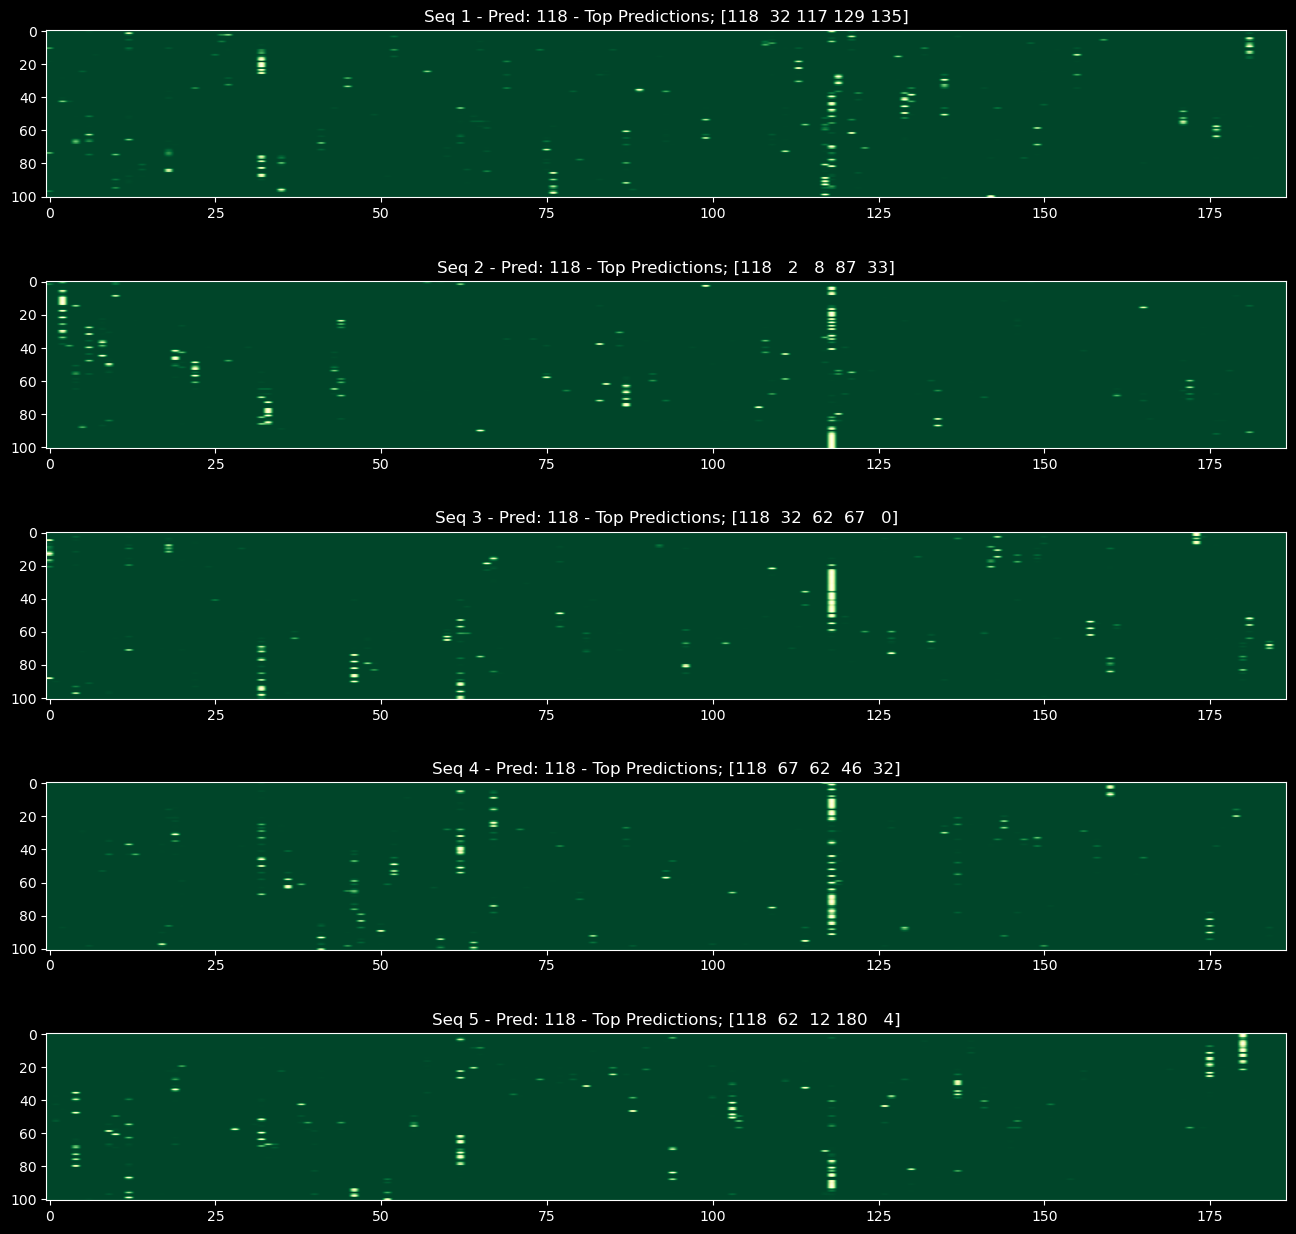

In [165]:
first_seq = 100
nb_seq = 5
s = slice(first_seq, first_seq+nb_seq)

plot_label_probs(probs_per_kmer[correct_pred_idxs][s,:,:], top_preds[correct_pred_idxs][s], [118])

#### False Positive Only

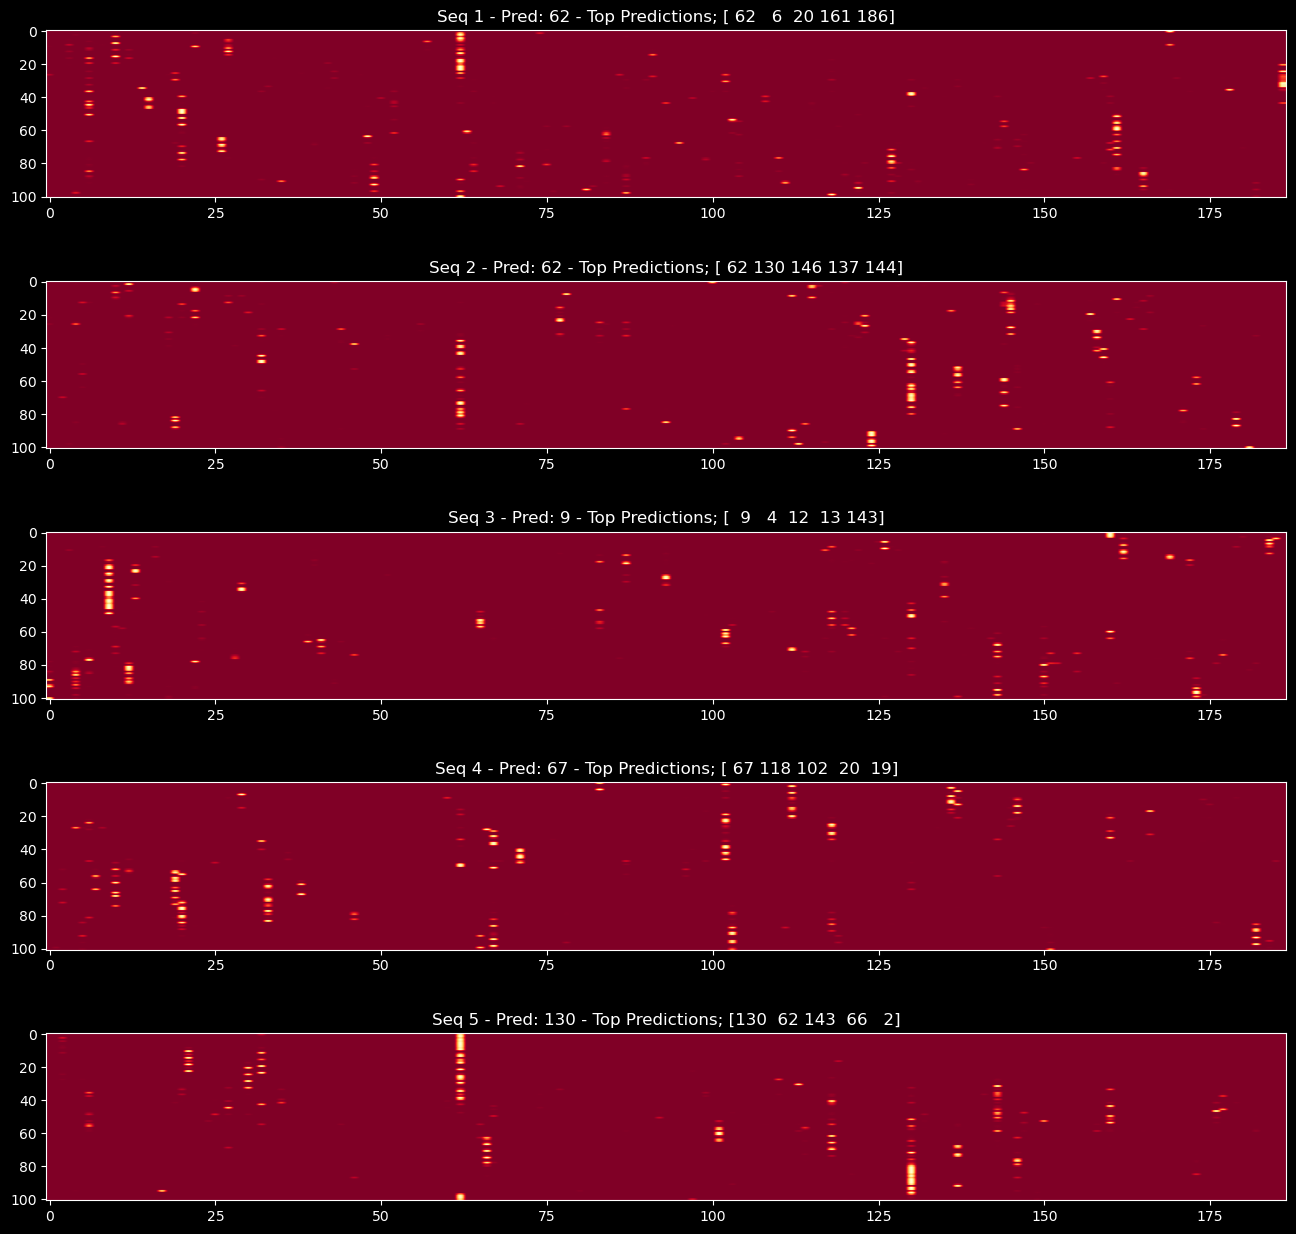

In [166]:
first_seq = 100
nb_seq = 5
s = slice(first_seq, first_seq+nb_seq)

plot_label_probs(probs_per_kmer[incorrect_pred_idxs][s,:,:], top_preds[incorrect_pred_idxs][s], [118])

## Load result in chunks

In [ ]:
p2resfile = pfs.project_root /'data/ncov_data/reads/yf/yf-mapped-results.csv'

def result_generator(p2file, chunksize=1000):
    for chunk in pd.read_csv(p2file, chunksize=chunksize, index_col=0):
        yield chunk

def get_chunk(p2file, chunknb, chunksize=1000):
    gen = result_generator(p2file, chunksize=chunksize)
    for i in range(chunknb):
        df = next(gen)
    return df

In [ ]:
chunk = get_chunk(p2resfile, chunknb=4, chunksize=1000)
chunk.shape

In [ ]:
probs_per_kmer = chunk[prob_cols].to_numpy().reshape(chunk.shape[0], -1, 187)
top_preds = chunk[top_pred_cols].to_numpy()
preds = top_preds[:, 0]

In [ ]:
correct_pred_idxs = preds == 118
incorrect_pred_idxs = preds != 118
true_positives = correct_pred_idxs.sum()
false_negatives = incorrect_pred_idxs.sum()
accuracy = true_positives/(true_positives + false_negatives)
print(f"True positives:  {true_positives}")
print(f"False negatives: {false_negatives}")
print(f"Accuracy:        {accuracy:.2%}")

#### Mixed Predictions

In [ ]:
first_seq = 0
nb_seq = 25
s = slice(first_seq, first_seq+nb_seq)

plot_label_probs(probs_per_kmer[s,:,:], top_preds[s], [118])

#### True Positive Only

In [ ]:
first_seq = 0
nb_seq = 25
s = slice(first_seq, first_seq + nb_seq)

plot_label_probs(probs_per_kmer[correct_pred_idxs][s,:,:], top_preds[correct_pred_idxs][s], [118])

#### False Positive Only

In [ ]:
first_seq = 0
nb_seq = 25
s = slice(first_seq, first_seq+nb_seq)

plot_label_probs(probs_per_kmer[incorrect_pred_idxs][s,:,:], top_preds[incorrect_pred_idxs][s], [118])

# Work with HDF5 Data Stores

### Create a DataFrame from an existing probability file

Create a `read_store` to read some of the probabilities

In [ ]:
paths = files_in_tree(path=p2fastq.parent)
paths[4].suffix == '.hdf5'

In [ ]:
p2probs = paths[4]
p2probs

In [ ]:
read_store = HDFStore(path=p2probs, mode='r')
keys = read_store.keys()
keys[:8]

In [ ]:
total_nb_labels = len(read_store.keys())
total_nb_labels

In [ ]:
nrows = 4096
nblabels = total_nb_labels
keys = read_store.keys()
df = read_store.select(key=keys[0], start=0, stop=nrows)
for k in tqdm(keys[1:]):
    df = pd.concat([df, read_store.select(key=k, start=0, stop=nrows)], axis=1)

In [ ]:
df.shape

In [ ]:
p2hdf5 = Path("temp.hdf5")
if p2hdf5.exists(): p2hdf5.unlink()

nblabels = 10
nrows = 32

# Store probabilities in hdf5 format, with one label per key

with HDFStore(path=p2hdf5, mode='a') as store:

    # Replace '/' in index as it is not supported by hdf5
    df.index = [idx.replace('/','-') for idx in df.index]
    cols = df.columns

    for n in trange(nblabels):
        label_cols = [c for c in cols if c.endswith(f"ProbL{n}")]
        store.put(
            key=f'label_{n:03d}', 
            value=df.iloc[:nrows, :].loc[:,label_cols], 
            format='table', 
            append=True, 
            index=True,
            data_columns=True
        )

    print(store.keys())

In [ ]:
with HDFStore(path=p2hdf5, mode='r') as store:
    print(store.get(key='/label_001').shape)

In [ ]:
with HDFStore(path=p2hdf5, mode='a') as store:

    # Replace '/' in index as it is not supported by hdf5
    df.index = [idx.replace('/','-') for idx in df.index]
    cols = df.columns

    for n in trange(nblabels):
        label_cols = [c for c in cols if c.endswith(f"ProbL{n}")]
        store.put(
            key=f'label_{n:03d}', 
            value=df.iloc[100:100+nrows, :].loc[:,label_cols], 
            format='table', 
            append=True, 
            index=True,
            data_columns=True
        )

    print(store.keys())

In [ ]:
with HDFStore(path=p2hdf5, mode='r') as store:
    print(store.get(key='/label_001').shape)

In [ ]:
with HDFStore(path=p2hdf5, mode='a') as store:

    # Replace '/' in index as it is not supported by hdf5
    df.index = [idx.replace('/','-') for idx in df.index]
    cols = df.columns

    for n in trange(nblabels):
        label_cols = [c for c in cols if c.endswith(f"ProbL{n}")]
        store.put(
            key=f'label_{n:03d}', 
            value=df.iloc[300:300+nrows, :].loc[:,label_cols], 
            format='table', 
            append=True, 
            index=True,
            data_columns=True
        )

    print(store.keys())

In [ ]:
with HDFStore(path=p2hdf5, mode='r') as store:
    print(store.get(key='/label_001').shape)